In [23]:
import re
import nltk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

In [24]:
dataset_path = "./sentiment_analysis.csv"
df = pd.read_csv(
    dataset_path,
    index_col="id"
)

In [25]:
df

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...
...,...,...
7916,0,Live out loud #lol #liveoutloud #selfie #smile...
7917,0,We would like to wish you an amazing day! Make...
7918,0,Helping my lovely 90 year old neighbor with he...


In [26]:
def text_normalize(text):
    # Retweet old acronym "RT" removal
    text = re.sub(r'RT[\s]+', '', text)

    # Hyperlink removal
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    # Hashtag removal
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokenizer = TweetTokenizer(
        preserve_case=False,
        strip_handles=True,
        reduce_len=True,
    )
    text_tokens = tokenizer.tokenize(text)
    return text_tokens

In [27]:
def get_freqs(df):
    freqs = defaultdict(lambda: 0)
    for idx, row in df.iterrows():
        tweet = row["tweet"]
        label = row["label"]

        tokens = text_normalize(tweet)
        for token in tokens:
            pair = (token, label)
            freqs[pair] += 1
        
    return freqs

In [28]:
def get_feature(text, freqs):
    tokens = text_normalize(text)

    x = np.zeros(3)
    x[0] = 1
    
    for token in tokens:
        x[1] += freqs[(token, 0)]
        x[2] += freqs[(token, 1)]

    return x

In [30]:
x = []
y = []

freqs = get_freqs(df)
for idx, row in df.iterrows():
    tweet = row["tweet"]
    label = row["label"]

    x_i = get_feature(tweet, freqs)
    x.append(x_i)
    y.append(label)

x = np.array(x)
y = np.array(y)

In [34]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

x_train, x_val, y_train, y_val = train_test_split(
    x, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle,
)

x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle,
)

In [35]:
normalizer = StandardScaler()
x_train[:, 1:] = normalizer.fit_transform(x_train[:, 1:])
x_val[:, 1:] = normalizer.transform(x_val[:, 1:])
x_test[:, 1:] = normalizer.transform(x_test[:, 1:])

In [36]:
# Sigmoid function
def calculate_sigmoid(z):
    return 1 / (1 + np.exp(-z))

# prediction
def predict(x, theta):
    z = np.dot(x, theta)
    y_hat = calculate_sigmoid(z)
    return y_hat

# Compute loss
def compute_loss(y, y_hat):
    y_hat_clipped = np.clip(y_hat, 1e-7, 1 - 1e-7)
    loss = (-y * np.log(y_hat_clipped) - (1 - y) * np.log(1 - y_hat_clipped)).mean()
    return loss

# Compute gradient
def compute_gradient(x, y, y_hat):
    m = len(y)
    gradient = np.dot(x.T, (y_hat - y)) / m
    return gradient

# Update weight
def update_weight(theta, gradient, lr):
    new_theta = theta - lr * gradient
    return new_theta

# Accuracy
def accuracy(x, y, theta):
    y_hat = predict(x, theta).round()
    acc = (y_hat == y).mean()
    return acc

In [37]:
lr = 0.01
epochs = 200
batch_size = 128
np.random.seed(random_state)
theta = np.random.uniform(size=x_train.shape[1])

In [38]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, x_train.shape[0], batch_size):
        x_i = x_train[i:i + batch_size]
        y_i = y_train[i:i + batch_size]
        
        # Training phase
        y_hat = predict(x_i, theta)

        train_loss = compute_loss(y_i, y_hat)
        train_batch_losses.append(train_loss)

        gradient = compute_gradient(x_i, y_i, y_hat)

        theta = update_weight(theta, gradient, lr)

        train_acc = accuracy(x_i, y_i, theta)
        train_batch_accs.append(train_acc)
        # Validation phase
        y_hat = predict(x_val, theta)

        train_loss = compute_loss(y_val, y_hat)
        val_batch_losses.append(train_loss)
        val_acc = accuracy(x_val, y_val, theta)
        val_batch_accs.append(val_acc)

    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    train_losses.append(train_batch_loss)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    train_accs.append(train_batch_acc)

    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    val_losses.append(val_batch_loss)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)
    val_accs.append(val_batch_acc)

    print(f"\nEPOCH: {epoch+1}/{epochs}:\tTraining Loss:{train_batch_loss:.3f}\tValidation Loss:{val_batch_loss:.3f}")



EPOCH: 1/200:	Training Loss:0.707	Validation Loss:0.704

EPOCH: 2/200:	Training Loss:0.661	Validation Loss:0.659

EPOCH: 3/200:	Training Loss:0.624	Validation Loss:0.622

EPOCH: 4/200:	Training Loss:0.593	Validation Loss:0.591

EPOCH: 5/200:	Training Loss:0.569	Validation Loss:0.566

EPOCH: 6/200:	Training Loss:0.548	Validation Loss:0.546

EPOCH: 7/200:	Training Loss:0.531	Validation Loss:0.529

EPOCH: 8/200:	Training Loss:0.516	Validation Loss:0.514

EPOCH: 9/200:	Training Loss:0.504	Validation Loss:0.502

EPOCH: 10/200:	Training Loss:0.494	Validation Loss:0.491

EPOCH: 11/200:	Training Loss:0.485	Validation Loss:0.483

EPOCH: 12/200:	Training Loss:0.477	Validation Loss:0.475

EPOCH: 13/200:	Training Loss:0.471	Validation Loss:0.468

EPOCH: 14/200:	Training Loss:0.465	Validation Loss:0.463

EPOCH: 15/200:	Training Loss:0.460	Validation Loss:0.457

EPOCH: 16/200:	Training Loss:0.456	Validation Loss:0.453

EPOCH: 17/200:	Training Loss:0.452	Validation Loss:0.449

EPOCH: 18/200:	Trainin

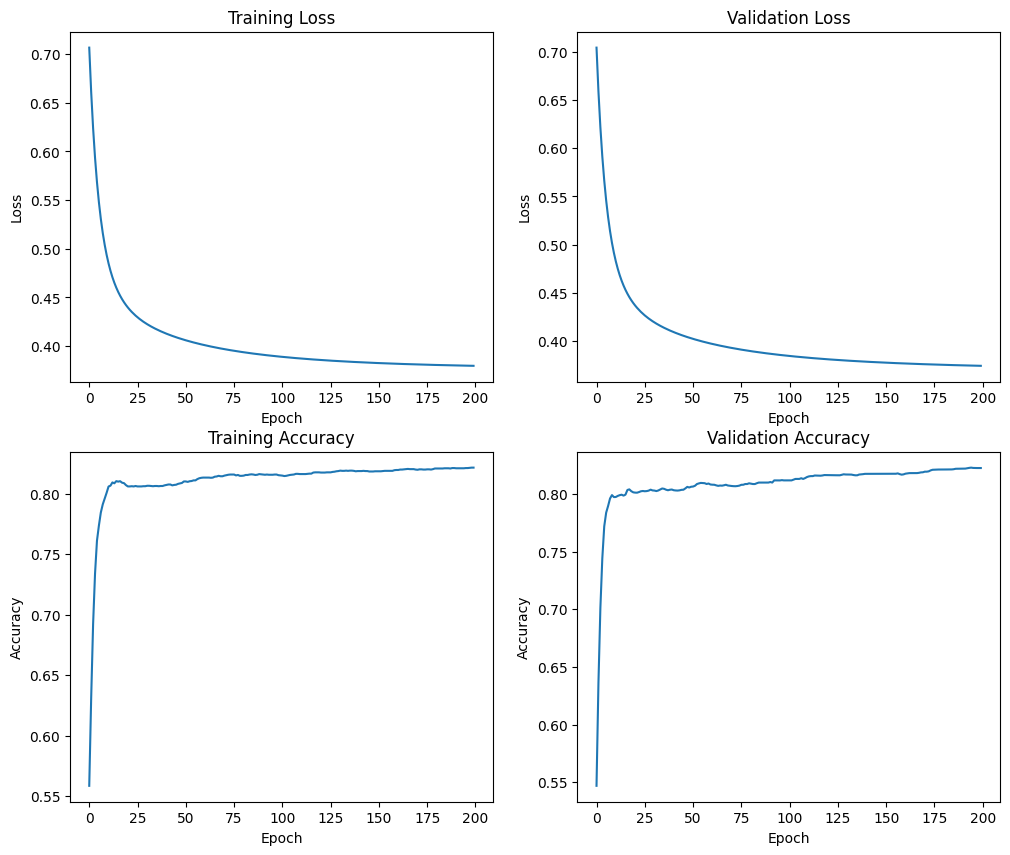

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
ax[0, 0].set_title("Training Loss")

ax[0, 1].plot(val_losses)
ax[0, 1].set(xlabel="Epoch", ylabel="Loss")
ax[0, 1].set_title("Validation Loss")

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 0].set_title("Training Accuracy")

ax[1, 1].plot(val_accs)
ax[1, 1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 1].set_title("Validation Accuracy")

plt.show()


In [40]:
val_set_acc = accuracy(x_val, y_val, theta)
test_set_acc = accuracy(x_test, y_test, theta)
print(f"Val Accuracy: {val_set_acc}")
print(f"Test accuracy: {test_set_acc}")

Val Accuracy: 0.82260101010101
Test accuracy: 0.8434343434343434
